<a href="https://colab.research.google.com/github/Mursalin1011/Stocks-BackTesting-python/blob/main/Stock_backtesting_practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install yfinance ta

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import BollingerBands

### Let's use AAPL for our backtesting

In [84]:
ticker = "AAPL"  # You can change this to any stock symbol
df = yf.download(ticker, start="2020-01-01", end="2024-12-31")
df = df[['Close']]  # We'll use only the closing price
df.dropna(inplace=True)


/tmp/ipython-input-2483857969.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


### We'll calculate MA 5 and MA 20

In [21]:
df['MA5'] = df['Close'].rolling(window=5).mean()
print(df['MA5'])
df['MA20'] = df['Close'].rolling(window=20).mean()

Date
2020-01-02           NaN
2020-01-03           NaN
2020-01-06           NaN
2020-01-07           NaN
2020-01-08     72.495598
                 ...    
2024-12-23    251.609055
2024-12-24    252.550790
2024-12-26    254.739508
2024-12-27    255.896716
2024-12-30    255.439813
Name: MA5, Length: 1257, dtype: float64


### Our Signal


> **Buy** when the 5-day Moving Average (MA) crosses **above** the 20-day MA.
<br>
> **Sell** when the 5-day MA crosses below the 20-day MA.



In [22]:
df['Signal'] = 0  # Initialize
df.loc[df['MA5'] > df['MA20'], 'Signal'] = 1
df.loc[df['MA5'] < df['MA20'], 'Signal'] = -1
df['Position'] = df['Signal'].shift(1)

In [23]:
# # Step 5: Generate Buy/Sell signals with "hold" and take-profit
# df['Signal'] = np.where(df['MA5'] > df['MA20'], 1,
#                  np.where(df['MA5'] < df['MA20'], -1, np.nan))
# df['Position'] = df['Signal'].ffill().fillna(0)

# # Track entries
# df['Trade Entry Price'] = np.nan
# entry_price = None

# for i in range(1, len(df)):
#     prev_pos = df['Position'].iloc[i - 1]
#     curr_pos = df['Position'].iloc[i]

#     # Record entry price on new long position
#     if prev_pos != 1 and curr_pos == 1:
#         entry_price = df['Close'].iloc[i]
#         df.at[df.index[i], 'Trade Entry Price'] = entry_price

#     # Maintain entry price across holding period
#     elif curr_pos == 1 and entry_price is not None:
#         df.at[df.index[i], 'Trade Entry Price'] = entry_price

#     # Reset entry price when exiting
#     elif curr_pos != 1:
#         entry_price = None

# # Check for take-profit
# take_profit_percent = 0.10
# for i in range(1, len(df)):
#     if df['Position'].iloc[i] == 1:
#         entry = df['Trade Entry Price'].iloc[i]
#         curr = df['Close'].iloc[i]
#         if pd.notna(entry) and (curr - entry) / entry >= take_profit_percent:
#             # Trigger take-profit exit
#             df.at[df.index[i], 'Position'] = 0


### Our custom strategy


In [87]:
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
print(type(df['Close']))
print(df['Close'].shape)
df['sq'] = df['Close'].values
print(df['Close'].values)


/tmp/ipython-input-2718637816.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
(1257, 1)
[[ 72.62085724]
 [ 71.91481018]
 [ 72.48787689]
 ...
 [258.39666748]
 [254.97492981]
 [251.59307861]]


In [88]:


# 🎯 --- Indicator Calculations ---

# ✅ MACD (EMA10/EMA20 custom MACD)
macd = MACD(close=df['Close'].values, window_fast=10, window_slow=20, window_sign=9)
print(macd)
df['MACD_Line'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
print(df.columns)
# # ✅ RSI (14)
# rsi = RSIIndicator(close=df['sq'], window=14)
# df['RSI'] = rsi.rsi()

# # ✅ ADX (14)
# # adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['sq'], window=14)
# # df['ADX'] = adx.adx()
# # df['ADX_Pos'] = adx.adx_pos()
# # df['ADX_Neg'] = adx.adx_neg()

# # ✅ OBV (On Balance Volume)
# obv = OnBalanceVolumeIndicator(close=df['sq'], volume=df['Volume'])
# df['OBV'] = obv.on_balance_volume()

# # ✅ Bollinger Bands (20 SMA, 2 Std)
# bb = BollingerBands(close=df['sq'], window=20, window_dev=2)
# df['BB_Middle'] = bb.bollinger_mavg()
# df['BB_Upper'] = bb.bollinger_hband()
# df['BB_Lower'] = bb.bollinger_lband()
# df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

# # ✅ Bollinger Band Squeeze Detection
# df['BB_Squeeze'] = df['BB_Width'] < df['BB_Width'].rolling(window=20).quantile(0.25)

# # ✅ EMA 20 & EMA 50
# df['EMA20'] = df['sq'].ewm(span=20, adjust=False).mean()
# df['EMA50'] = df['sq'].ewm(span=50, adjust=False).mean()

# # 🧼 Clean up any leftover NaNs from indicators
# df.dropna(inplace=True)

# # ✅ Preview final DataFrame (last few rows)
# df[['Close', 'MACD_Line', 'MACD_Signal', 'RSI', 'ADX', 'OBV', 'BB_Lower', 'BB_Upper', 'BB_Squeeze', 'EMA20', 'EMA50']].tail()


AttributeError: 'numpy.ndarray' object has no attribute 'ewm'

### Simulation of trades

In [24]:
initial_cash = 100000
df['Daily Return'] = df['Close'].pct_change()
df['Strategy Return'] = df['Daily Return'] * df['Position']
df['Cumulative Market Return'] = (1 + df['Daily Return']).cumprod()
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()

### Plotting the results

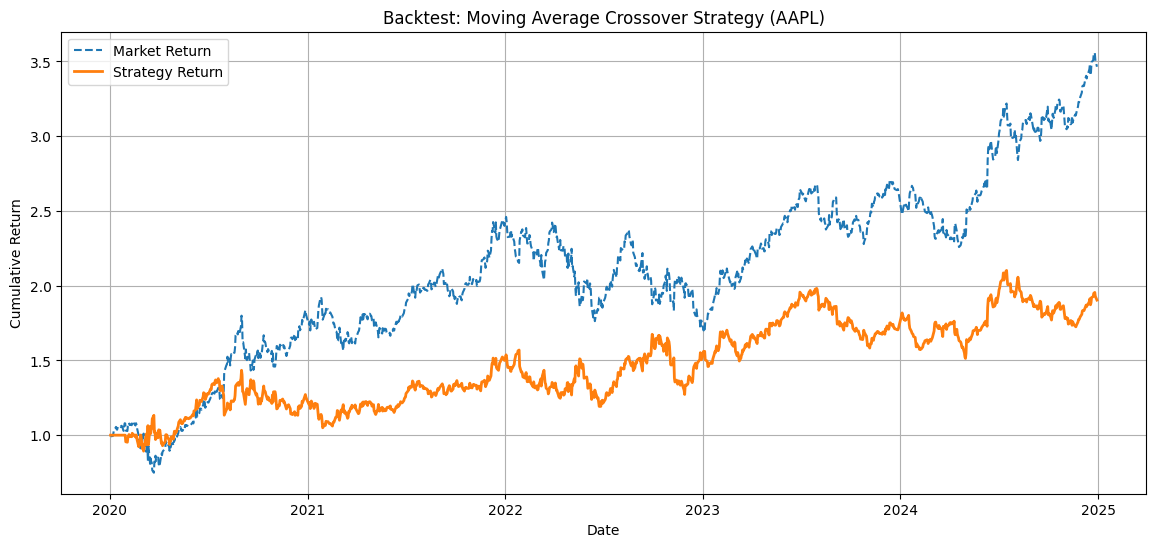

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(df['Cumulative Market Return'], label='Market Return', linestyle='--')
plt.plot(df['Cumulative Strategy Return'], label='Strategy Return', linewidth=2)
plt.title(f"Backtest: Moving Average Crossover Strategy ({ticker})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
total_return = df['Cumulative Strategy Return'].iloc[-1] - 1
market_return = df['Cumulative Market Return'].iloc[-1] - 1
num_trades = df['Position'].diff().abs().sum()

sharpe_ratio = np.mean(df['Strategy Return']) / np.std(df['Strategy Return']) * np.sqrt(252)

print(f"🔹 Total Strategy Return: {total_return:.2%}")
print(f"🔹 Buy & Hold Return:     {market_return:.2%}")
print(f"🔹 Number of Trades:      {num_trades:.0f}")
print(f"🔹 Sharpe Ratio:          {sharpe_ratio:.2f}")

🔹 Total Strategy Return: 90.34%
🔹 Buy & Hold Return:     246.45%
🔹 Number of Trades:      121
🔹 Sharpe Ratio:          0.57
